__собираем статистики по объявлениям о продаже квартир__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Ср 29 мар 2023 16:42:34 MSK


In [2]:
# !pip install plotly ipywidgets plotly-geo

In [3]:
# import re
# import numpy as np
# from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
# import plotly
# import contextily as ctx
# from shapely.geometry import Polygon

In [4]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
# tqdm.pandas()
# pd.options.plotting.backend = 'plotly'

In [5]:
# !ls -1 data

In [6]:
# import shapely
# shapely.__version__
# '1.8.4'

In [7]:
# !pip install greppo==0.0.32
# !pip install shapely==1.8.2

In [8]:
# !pip install --upgrade pip

In [9]:
# !pip install --upgrade pygeos==0.10.2

In [10]:
# !pip freeze > requirements.txt
# !pip install -r requirements.txt

## считываем данные

In [11]:
data_file = 'data/data_flat.pkl'

In [12]:
cols = ['title','adr','latitude','longitude','priceM','dt']
df = pd.read_pickle(data_file)
# df['dt'] = pd.to_datetime( df['ts'].dt.date )
df['dt'] = df['ts'].dt.date
print(len(df))
df.sample(3)[cols]

86446


title  \
76497     1-к. квартира, 30,3 м², 4/5 эт.   
6534   1-к. апартаменты, 14,2 м², 2/2 эт.   
43823  апартаменты-студия, 23 м², 4/4 эт.   

                                               adr  latitude longitude  \
76497            Севастополь, улица Меньшикова, 19     44.59     33.48   
6534   Севастополь, Кача, Первомайская улица , 72А     44.77     33.54   
43823          Севастополь, улица Челнокова, 19Ак4  44.59567  33.43101   

       priceM          dt  
76497    6.80  2022-11-28  
6534     2.70  2022-08-29  
43823    6.45  2022-09-16

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86446 entries, 0 to 86445
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   title          86446 non-null  object        
 1   price          86446 non-null  int64         
 2   adr_orig       86446 non-null  object        
 3   description    86360 non-null  object        
 4   obj_name       27153 non-null  object        
 5   ts             86446 non-null  datetime64[ns]
 6   avito_page     84458 non-null  float64       
 7   place          86446 non-null  object        
 8   nrooms         86446 non-null  int64         
 9   floor          86446 non-null  int64         
 10  nfloors        86446 non-null  int64         
 11  area           86446 non-null  float64       
 12  is_studio      86446 non-null  bool          
 13  is_apartment   86446 non-null  bool          
 14  is_part        86446 non-null  bool          
 15  is_auction     8644

In [14]:
df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )


# gdf[ gdf['title'].str.lower().str.match(r'дом 2'latitude','longitude'23,2.*') ]
df.loc[ df['adr_orig']=='квартал Старый Город', ['latitude','longitude']] = None
df.loc[ df['url']=='https://avito.ru/2322251740', ['latitude','longitude']] = None

df.loc[ df['adr_orig']=='Севастополь, Чёрное море', ['latitude','longitude'] ] = None
df.loc[ df['adr_orig'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 
df.loc[ df['adr_orig'].str.lower().str.match('анталья'), ['latitude','longitude'] ] = None 

df.loc[ df['longitude']<30., ['latitude','longitude'] ] = None 


In [15]:
# df[['latitude','longitude']].drop_duplicates().min()

# df.query('longitude<27.89')

# latitude    41.02
# longitude   27.79

# latitude    44.86
# longitude   33.78

In [16]:
# df.columns

In [17]:
# берём объявления с геометкой
print(len(df))
df = df[ 
    ~( df['latitude'].isnull()| df['longitude'].isnull() ) 
].reset_index(drop=True)
print(len(df))

86446
86429


In [18]:
# # берём объявления с геометкой
# print(len(df))
# df = df[ (~df['latitude'].isnull()) ].reset_index(drop=True)
# print(len(df))

### ограничиваем тип объекта 

In [19]:
print(len(df))
# выкидываем "ущербные" варианты 
df = df.query('~(is_studio|is_apartment|is_part|is_auction|is_openspace|is_SNT|is_roof)&(nrooms>0)&(nrooms<4)')
print(len(df))
df = df.query('priceM>1.') # выкидываем предожения с аномально низкой ценой
print(len(df))

86429
69764
69764


In [20]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
gdf.sample(3)[['title','adr','latitude','longitude','priceM']]

title  \
19361  1-к. квартира, 29,8 м², 2/3 эт.   
33322    1-к. квартира, 33 м², 6/9 эт.   
4127   1-к. квартира, 35,7 м², 8/9 эт.   

                                                    adr  latitude  longitude  \
19361  Севастополь,ТСН Родник, улица Ивана Марченко, 15     44.54      33.56   
33322     Севастополь, проспект Генерала Острякова, 204     44.56      33.52   
4127           Севастополь, улица Павла Корчагина, 23/1     44.59      33.43   

       priceM  
19361    1.75  
33322    5.90  
4127     6.40

In [21]:
df.sample(10)[['title','adr','url']].to_dict('records') 

[{'title': '2-к. квартира, 42,1\xa0м², 4/5\xa0эт.',
  'adr': 'Севастополь, улица Героев Севастополя, 46',
  'url': 'https://avito.ru/2510199882'},
 {'title': '1-к. квартира, 53,6\xa0м², 5/5\xa0эт.',
  'adr': 'Севастополь, улица Челнокова, 17 к1',
  'url': 'https://avito.ru/2455992105'},
 {'title': '1-к. квартира, 31\xa0м², 4/5\xa0эт.',
  'adr': 'Севастополь, улица Лизы Чайкиной, 99К1',
  'url': 'https://avito.ru/2379667671'},
 {'title': '2-к. квартира, 84\xa0м², 6/10\xa0эт.',
  'adr': 'Севастополь, улица Генерала Крейзера, д. 8, корп. 7',
  'url': 'https://avito.ru/2468694427'},
 {'title': '2-к. квартира, 50\xa0м², 11/12\xa0эт.',
  'adr': 'Севастополь, проспект Генерала Острякова, 188',
  'url': 'https://avito.ru/2443158781'},
 {'title': '3-к. квартира, 65\xa0м², 6/6\xa0эт.',
  'adr': 'Севастополь, улица Ленина, 24',
  'url': 'https://avito.ru/2317664724'},
 {'title': '3-к. квартира, 42\xa0м², 1/2\xa0эт.',
  'adr': 'Севастополь, улица Багрия, 57',
  'url': 'https://avito.ru/2489505651'

In [22]:
del df

In [23]:
gdf[['title','adr','priceM','geometry']].sample(100).explore()

## общая статистика

### количество предложений

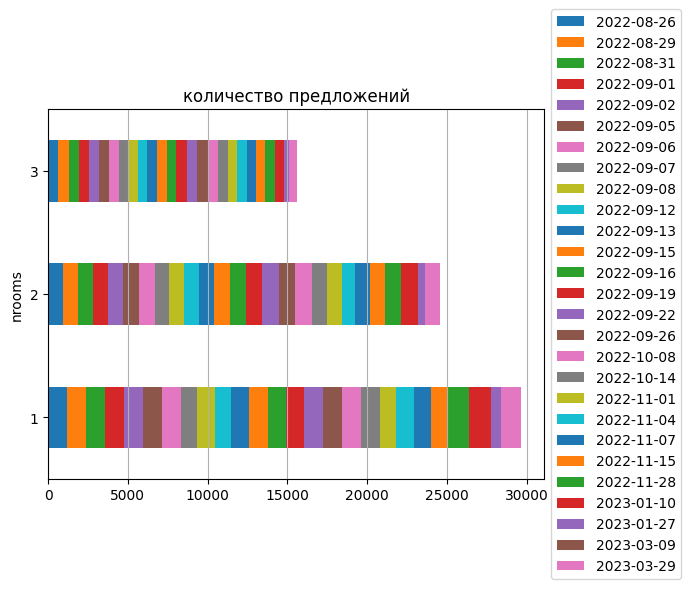

In [24]:
fig = ( # количество предложений
    gdf
    .groupby(['dt','nrooms'])
    .size().reset_index()
    .pivot(index='nrooms', columns='dt', values=0)
    .plot
    .barh(legend=False,title='количество предложений',stacked=True)
)
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

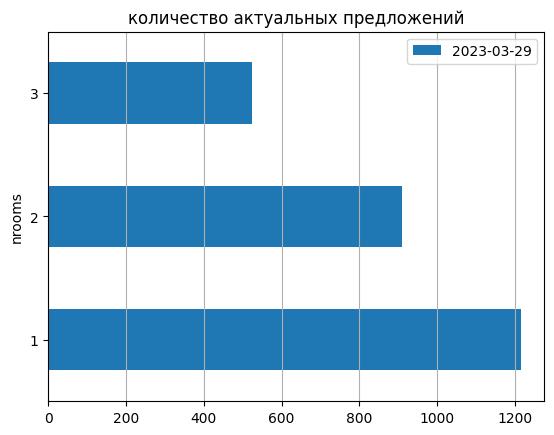

In [25]:
fig = ( # количество актуальных предложений
    gdf[ gdf['dt'] == gdf['dt'].max() ]
    .groupby(['dt','nrooms'])
    .size().reset_index()
    .pivot(index='nrooms', columns='dt', values=0)
    .plot
    .barh( legend=False,title='количество актуальных предложений') #, stacked=True )
)
fig.legend() # loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

### изменение цены

In [26]:
stat = gdf.groupby(['nrooms','dt'])['priceM'].describe(percentiles=[.01,.05,.1,.25,.5,.75,.9])

In [27]:
# import matplotlib.pyplot as plt

# sizes = [1,2,3,]
# cols = ['min','1%','5%','25%','50%']
# fig, ax = plt.subplots(1,len(sizes),figsize=(17,5), sharey=False )
# for i,k in enumerate(sizes): 
#     stat.loc[k,cols].plot(title=f'цена на {k}к', grid=True,ax=ax[i],legend=False, rot=70 )   
    
# fig.suptitle(locations, fontsize=16)
# fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
# fig.tight_layout()

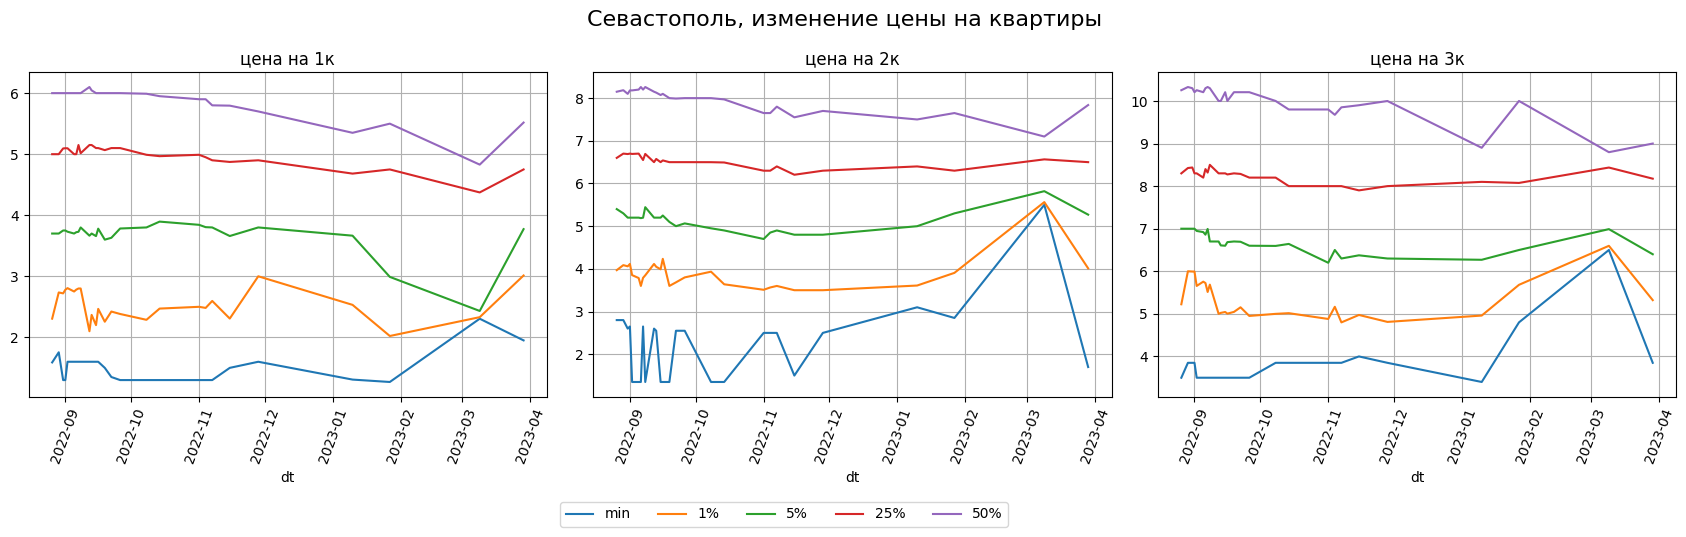

In [28]:
import matplotlib.pyplot as plt

sizes = [1,2,3,]
cols = ['min','1%','5%','25%','50%']
fig, ax = plt.subplots(1,len(sizes),figsize=(17,5), sharey=False )
for i,k in enumerate(sizes): 
    stat.loc[k,cols].plot(title=f'цена на {k}к', grid=True,ax=ax[i],legend=False, rot=70 )   

fig.suptitle('Севастополь, изменение цены на квартиры', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

In [29]:
stat = stat.reset_index()
dtm = stat['dt'].max()
stat[stat['dt']==dtm][['nrooms','min','1%','5%','25%','50%','75%','90%','max']]

nrooms  min   1%   5%  25%  50%   75%   90%   max
26       1 1.95 3.01 3.77 4.75 5.52  6.61  8.04 48.00
53       2 1.70 4.01 5.27 6.50 7.84  9.50 12.00 35.00
80       3 3.85 5.32 6.40 8.18 9.00 12.50 16.00 70.00

### гексагональная сетка и медиана актуальной цены

In [30]:
from shapely.geometry import MultiPoint

frame_all = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

frame_all.explore()


In [31]:
# frame_all.to_file('data/frame_all.geojson', driver='GeoJSON')

In [32]:
import h3
from shapely.geometry import Polygon

def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [33]:
grid = cover_grid_hexagonal( frame_all.geometry.values[0],cell_size=6 )
print(len(grid))
grid.sample(2)

24


hex_id  \
19  862d28967ffffff   
6   862d28847ffffff   

                                                                                                                                           geometry  
19  POLYGON ((33.41695 44.64997, 33.39555 44.62051, 33.42254 44.59175, 33.47089 44.59244, 33.49229 44.62190, 33.46533 44.65066, 33.41695 44.64997))  
6   POLYGON ((33.71251 44.59560, 33.69105 44.56620, 33.71787 44.53737, 33.76613 44.53794, 33.78760 44.56734, 33.76080 44.59617, 33.71251 44.59560))

In [34]:
grid_values = ( 
    grid
    .sjoin( gdf[ gdf['dt']==gdf['dt'].max() ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## ограничиваем по район поиска

In [35]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
    { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
    for nm,f in frames_index.values
],crs='epsg:4326',)

frames

area_name  \
0     Севастополь, район Острякова   
1  Севастополь, парк 60-летия СССР   
2  Севастополь, Хрусталёва/Хрюкина   
3  Севастополь, Геловани/Коломийца   
4     Севастополь, Музыки/Бирюзова   
5            Севастополь, кр.горка   
6      Севастополь, Малахов курган   

                                                                                                                                                                                geometry  
0  POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))  
1                                                           POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))  
2                     POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))  
3                     POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))  
4                                                           POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))  
5  POLYGON ((33.53426 44.59526, 33.54470 44.58945, 33.54804 44.58596, 33.55346 44.58519, 33.55707 44.57912, 33.56296 44.57711, 33.54048 44.56941, 33.53004 44.59308, 33.53426 44.59526))  
6                                        POLYGON ((33.54313 44.60612, 33.55331 44.61155, 33.55676 44.60803, 33.55772 44.60255, 33.55385 44.60019, 33.54414 44.60247, 33.54313 44.60612))

In [36]:
frames.explore('area_name', legend=True)

In [37]:
# frames.to_file('data/frames.geojson', driver='GeoJSON')

In [38]:
area_name=[
#'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
'Севастополь, район Острякова',
# 'Севастополь, Малахов курган',
]

# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
print(len(gdf))
gdf_ = gdf.sjoin( frame_, how='inner', predicate='within') 
print(len(gdf_))

69764
7601


In [39]:
frames.iloc[[0]]

area_name  \
0  Севастополь, район Острякова   

                                                                                                                                                                                geometry  
0  POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))

In [40]:
# новые (актуальные) предложения
# gdf_[gdf_['ts']>ts][['title','priceM','adr','geometry']].explore( legend=False)
gdf_[['title','priceM','adr','geometry']].explore( legend=False)

In [41]:
locations = ' | '.join(area_name)
locations

'Севастополь, район Острякова'

### количество предложений

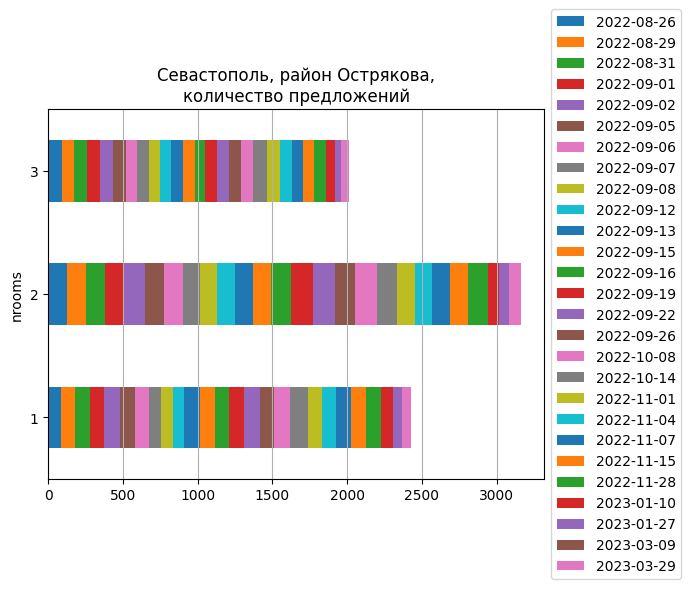

In [42]:
fig = ( # количество предложений
    gdf_.groupby(['dt','nrooms'])
    .size().reset_index()
    .pivot(index='nrooms', columns='dt', values=0)
    .plot.barh(legend=False,title=f'{locations},\nколичество предложений',stacked=True)
)
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

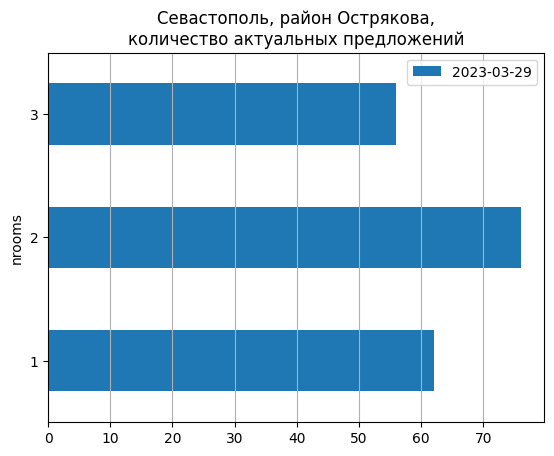

In [43]:
fig = ( # количество актуальных предложений
    gdf_[ gdf_['dt'] == gdf_['dt'].max() ]
    .groupby(['dt','nrooms'])
    .size().reset_index()
    .pivot(index='nrooms', columns='dt', values=0)
    .plot.barh(legend=False,title=f'{locations},\nколичество актуальных предложений',stacked=True)

)
fig.legend() #loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

### изменение цены

In [44]:
stat = gdf_.groupby(['nrooms','dt',])['priceM'].describe(percentiles=[.01,.05,.1,.25,.5,.75,.9])
# stat

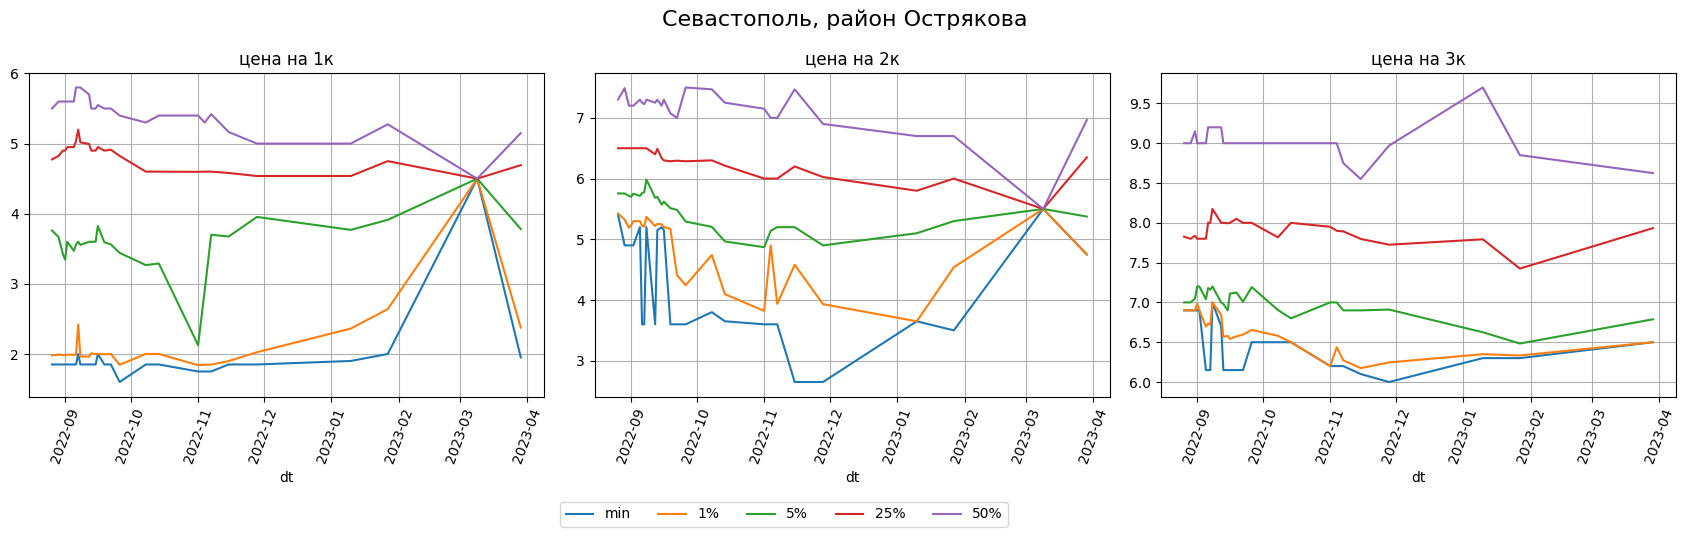

In [45]:
import matplotlib.pyplot as plt

sizes = [1,2,3,]
cols = ['min','1%','5%','25%','50%']
fig, ax = plt.subplots(1,len(sizes),figsize=(17,5), sharey=False )
for i,k in enumerate(sizes): 
    stat.loc[k,cols].plot(title=f'цена на {k}к', grid=True,ax=ax[i],legend=False, rot=70 )   
    
fig.suptitle(locations, fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

In [46]:
stat = stat.reset_index()
dtm = stat['dt'].max()
stat[stat['dt']==dtm][['nrooms','min','1%','5%','25%','50%','75%','90%','max']]

nrooms  min   1%   5%  25%  50%  75%   90%   max
26       1 1.95 2.38 3.78 4.69 5.15 5.90  6.98 11.99
53       2 4.75 4.75 5.38 6.35 6.96 8.33  9.95 15.00
79       3 6.50 6.50 6.79 7.93 8.62 9.77 12.35 16.70

### гексагональная сетка и  медиана актуальной цены

In [47]:
grid = cover_grid_hexagonal( frame_.geometry.values[0], cell_size=9 )
print(len(grid))
grid.sample(2)

54


hex_id  \
22  892d2894283ffff   
35  892d289424fffff   

                                                                                                                                           geometry  
22  POLYGON ((33.51872 44.57764, 33.51839 44.57585, 33.52048 44.57469, 33.52289 44.57531, 33.52321 44.57710, 33.52113 44.57827, 33.51872 44.57764))  
35  POLYGON ((33.53475 44.56476, 33.53442 44.56297, 33.53651 44.56181, 33.53892 44.56244, 33.53924 44.56423, 33.53716 44.56539, 33.53475 44.56476))

In [48]:
grid_values = ( 
    grid
    .sjoin( gdf[ gdf['dt']==gdf['dt'].max() ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)